In [39]:
import numpy as np
import pandas as pd
from pylab import plt
import seaborn as sns
import plotly.plotly as py
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

plt.style.use('seaborn')
%matplotlib inline
init_notebook_mode(connected=True)

import fxcmpy
con = fxcmpy.fxcmpy(config_file = 'fxcm.cfg', server='demo')

In [40]:
def z(df):
    return (df - df.mean()) / df.std()

In [3]:
symbol_info = con.get_offers(kind='dataframe')

In [4]:
symbol_swap = symbol_info[['currency', 'rollB', 'rollS']]
symbol_swap.index = symbol_swap['currency']
symbol_swap.drop(['currency'],axis=1, inplace=True)
symbol_swap

/anaconda2/envs/fxcm/lib/python3.7/site-packages/pandas/core/frame.py:3930: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,rollB,rollS
currency,,
EUR/USD,-38.790,18.000
USD/JPY,13.800,-29.250
GBP/USD,-25.650,12.510
USD/CHF,16.770,-37.260
EUR/CHF,2.310,-4.860
AUD/USD,-6.960,2.670
USD/CAD,4.230,-9.480
NZD/USD,-8.760,2.550
EUR/GBP,-15.000,7.110


In [13]:
#symbols = con.get_instruments()
#symbols = ['EUR/USD', 'USD/JPY', 'GBP/USD', 'USD/CAD', 'USD/CHF', 'AUD/USD', 'NZD/USD']
#symbols = ['EUR/USD', 'EUR/NZD', 'EUR/CAD', 'EUR/CHF', 'EUR/AUD', 'EUR/JPY']
#symbols = ['AUD/CAD', 'AUD/CHF', 'AUD/JPY', 'AUD/NZD']
symbols = ['EUR/USD', 'USD/JPY', 'GBP/USD', 'USD/CAD', 'USD/CHF', 'AUD/USD', 'NZD/USD', 'EUR/AUD', 'EUR/CAD', 'EUR/CHF', 'EUR/GBP', 'EUR/JPY', 'EUR/NZD', 'GBP/AUD', 'GBP/CAD', 'GBP/CHF', 'GBP/JPY', 'GBP/NZD', 'AUD/CAD', 'AUD/CHF', 'AUD/JPY', 'AUD/NZD', 'NZD/CAD', 'NZD/CHF', 'NZD/JPY', 'CAD/CHF', 'CAD/JPY', 'CHF/JPY']

In [41]:
symbols = ['AUD/JPY']

In [42]:
df = dict()
for symbol in symbols:
    df[symbol] = con.get_candles(symbol, period='D1', number=252) #1 Years
    df[symbol]['Close'] = (df[symbol]['bidclose'] + df[symbol]['askclose']) / 2

In [43]:
for symbol in symbols:
    df[symbol]['Close_z'] = z(df[symbol]['Close'])

In [35]:
symbols_focus = dict()

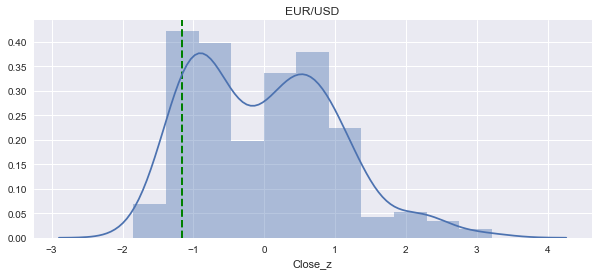

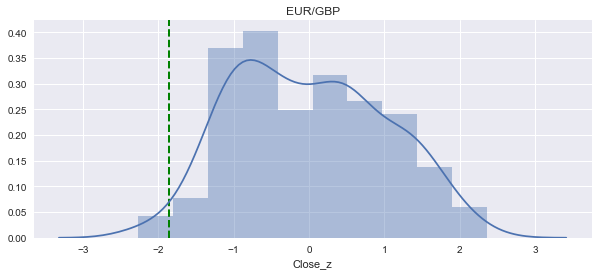

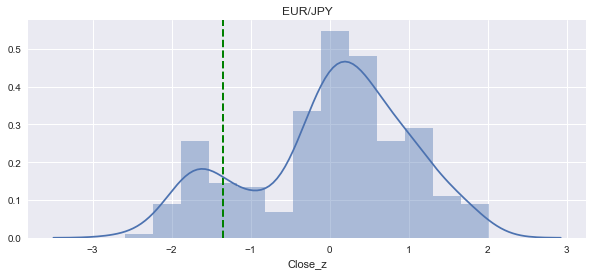

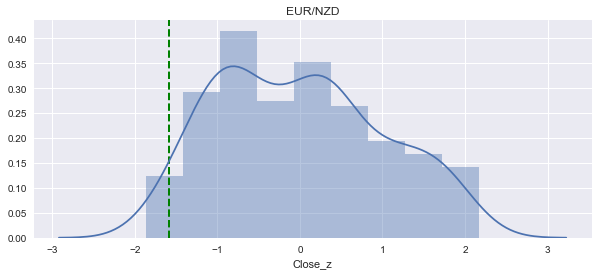

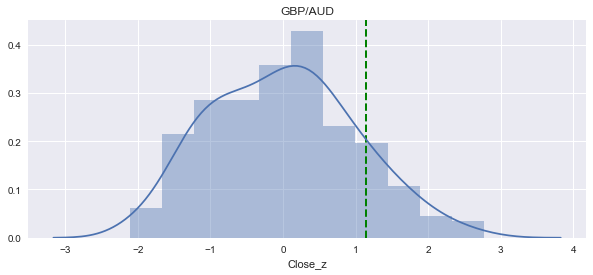

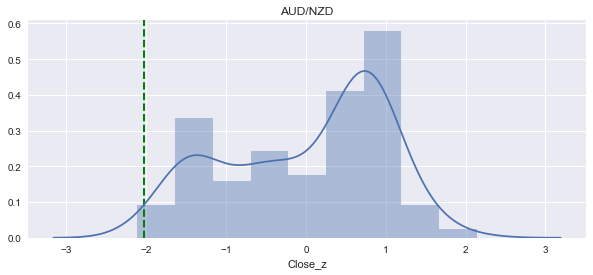

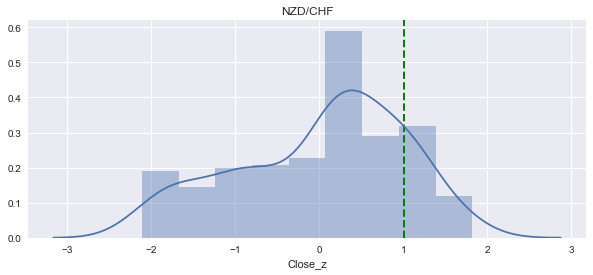

In [36]:
for symbol in symbols:
    if (df[symbol].iloc[-1]['Close_z'] > 1 or df[symbol].iloc[-1]['Close_z'] < -1):
        symbols_focus[symbol] = df[symbol]
        plt.figure(figsize=(10,4))
        plt.axvline(x=df[symbol].iloc[-1]['Close_z'], color='green', linestyle='--', linewidth=2)
        plt.title(symbol)
        sns.distplot(df[symbol]['Close_z'])

In [44]:
symbols_focus = symbols

In [45]:
def getRP(price, symbol, stoploss):
    exchange = {
        'USD': 1,
        'JPY': 0.00904702,
        'CAD': 0.755954,
        'CHF': 0.997029,
        'GBP': 1.29598,
        'NZD': 0.684647,
        'AUD': 0.715733
    }
    point = 10000
    pipval = 10/100
    rp = (price - stoploss) * point * pipval
    s = symbol.split('/')
    rp = rp * exchange[s[1]]
    return rp

AUD/JPY Zone [stop@4SD]
zone1: $97.0
zone2: $97.0
zone3: $65.0
zone4: $32.0
Total RP: $291.0




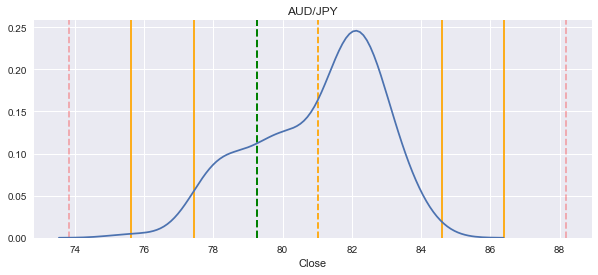

In [46]:
for symbol in symbols_focus:
    
    mean = np.mean(df[symbol]['Close'])
    sd = np.std(df[symbol]['Close'])
    high = np.max(df[symbol]['askhigh'])
    low = np.min(df[symbol]['asklow'])
     
    plt.figure(figsize=(10,4))
    plt.axvline(x=df[symbol].iloc[-1]['Close'], color='green', linestyle='--', linewidth=2)
    plt.axvline(x=mean, color='orange', linestyle='--')
    plt.axvline(x=mean+sd*2, color='orange')
    plt.axvline(x=mean-sd*2, color='orange')
    plt.axvline(x=mean+sd*3, color='orange')
    plt.axvline(x=mean-sd*3, color='orange')
    plt.axvline(x=mean+sd*4, color='red', linestyle='--', alpha=0.3)
    plt.axvline(x=mean-sd*4, color='red', linestyle='--', alpha=0.3)
    plt.title(symbol)
    
    
    zone = [0, 1, 2, 3]
    bullet_zone = 1
    stoploss = mean-sd*4
    print(symbol + ' Zone [stop@4SD]')
    #print("swap: \n" + str(symbol_swap.loc[symbol]))
    zone[0] = round(getRP(high, symbol, stoploss),0 )
    zone[1] = round(getRP(mean+sd*2, symbol, stoploss), 0)
    zone[2] = round(getRP(mean, symbol, stoploss), 0)
    zone[3] = round(getRP(mean-sd*2, symbol, stoploss), 0)
    for i in range(4):    
        print("zone" + str(i+1) + ": $" + str(zone[i] * bullet_zone))
    
    z = np.array(zone)
    print("Total RP: $" + str(z.sum() * bullet_zone))
    
    
    print("\n")
        
    sns.distplot(df[symbol]['Close'], hist=False)